## Analisis detallado (clase 1)
1. Inspeccion de columnas del dataframe y revisar los tipos de datos
2. Creacion de nuevas columnas que ayuden al analisis
3. Revision de la existencia de datos faltante y duplicados

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from IPython.display import HTML

In [6]:
def poner_fecha_string(df, date_string):
    date_obj = pd.to_datetime(date_string)
    df['fecha'] = date_obj

def crear_categoria(df):
    df['categoria'] = df['productos_descripcion'].apply(lambda x: str(x).split()[0].lower())

def cargar_sucursales(df, sucursales_df):
    for _, row in sucursales_df.iterrows():

        mascara = df['id_sucursal'] == row['id_sucursal']
        df.loc[mascara, 'sucursal_nombre'] = row['sucursales_nombre']
        df.loc[mascara, 'sucursal_tipo'] = row['sucursales_tipo']
        df.loc[mascara, 'sucursal_calle'] = row['sucursales_calle']
        df.loc[mascara, 'sucursal_latitud'] = row['sucursales_latitud']
        df.loc[mascara, 'sucursal_longitud'] = row['sucursales_longitud']
        df.loc[mascara, 'sucursal_barrio'] = row['sucursales_barrio']
        df.loc[mascara, 'sucursal_localidad'] = row['sucursales_localidad']
        df.loc[mascara, 'sucursal_provincia'] = row['sucursales_provincia']

    display(HTML(f"<span style='color: green;'> Datos de sucursales cargados exitosamente.</span>"))


In [7]:

tipos_de_datos = {
    "id_comercio": str, # texto, dado que no se hacen operaciones con este campo
    "id_bandera": np.float64,
    "id_sucursal": np.float64,
    "id_producto": np.float64,
    "productos_ean": np.float64,
    "productos_descripcion": str,
    "productos_cantidad_presentacion": np.float64,
    "productos_unidad_medida_presentacion": str,
    "productos_marca": str,
    "productos_precio_lista": np.float64,
    "productos_precio_referencia": np.float64,
    "productos_cantidad_referencia": np.float64,
    "productos_unidad_medida_referencia": str,
    "productos_precio_unitario_promo1": np.float64,
    "productos_leyenda_promo1": str,
    "productos_precio_unitario_promo2": np.float64,
    "productos_leyenda_promo2": str,
}

In [8]:
# Cargar de dataframe con las sucursales

# ultimo archivo de sucursales subido 
sucursales_path = "datos/7_4_25/sepa_1_comercio-sepa-10_2025-04-07_09-05-10/sucursales.csv" 

sucursales_df = pd.read_csv(sucursales_path, sep='|', header=0)

# Eliminar la última fila ya que contine una anotacion la 
# fecha de la utlima actualizacion del archivo
sucursales_df = sucursales_df.iloc[:-1, :]


In [9]:


# declaracion de los archivos con los que se trabajara
dic_fecha_producto = {
    "2025-04-1" : 'datos/1_4_25/sepa_1_comercio-sepa-10_2025-04-01_09-05-11/productos.csv',
    "2025-04-2" : 'datos/2_4_25/sepa_1_comercio-sepa-10_2025-04-02_09-05-11/productos.csv',
    "2025-04-3" : 'datos/3_4_25/sepa_1_comercio-sepa-10_2025-04-03_09-05-10/productos.csv',
    "2025-04-4" : 'datos/4_4_25/sepa_1_comercio-sepa-10_2025-04-04_09-05-10/productos.csv',
    "2025-04-5" : 'datos/5_4_25/sepa_1_comercio-sepa-10_2025-04-05_09-05-10/productos.csv',
    "2025-04-6" : 'datos/6_4_25/sepa_1_comercio-sepa-10_2025-04-06_09-05-10/productos.csv',
    "2025-04-7" : 'datos/7_4_25/sepa_1_comercio-sepa-10_2025-04-07_09-05-10/productos.csv',
}

# cargado de los archivos y limpieza de los datos para responder la pregunta del ejercicio
# se evita cargar y concatenar los archivos en memoria, ya que son muy grandes
df_agrupado = pd.DataFrame()

for fecha, path in dic_fecha_producto.items():
    # se declaran los tipos de datos y se evitar cargar el encabezado  
    df = pd.read_csv(path, sep='|', dtype=tipos_de_datos, header=0)

    # Eliminar la última fila ya que contine una anotacion la 
    # fecha de la utlima actualizacion del archivo
    df = df.iloc[:-1, :]


    poner_fecha_string(df, fecha)
    crear_categoria(df)

    df_agrupado = pd.concat([df_agrupado, df], ignore_index=True)
    
    display(HTML(f"<span style='color: green;'> Sepa {fecha} cargada exitosamente. [{len(df)}] filas</span>"))

del df # se elimna la variable df para liberar memoria



In [10]:
cargar_sucursales(df_agrupado, sucursales_df)

In [11]:
df_agrupado.isnull().sum()

id_comercio                                    0
id_bandera                                     0
id_sucursal                                    0
id_producto                                    0
productos_ean                                  0
productos_descripcion                          0
productos_cantidad_presentacion                0
productos_unidad_medida_presentacion           0
productos_marca                                0
productos_precio_lista                         0
productos_precio_referencia                    0
productos_cantidad_referencia                  0
productos_unidad_medida_referencia             0
productos_precio_unitario_promo1        15012513
productos_leyenda_promo1                15012513
productos_precio_unitario_promo2        15557316
productos_leyenda_promo2                15557316
fecha                                          0
categoria                                      0
sucursal_nombre                                0
sucursal_tipo       

In [12]:
#agregar columnas cambio_diferencia y cambio_precio

df_ordenado = df_agrupado.sort_values(by='fecha', ascending=True)
df_agrupado_X_producto_sucursal = df_ordenado.groupby(['id_producto', 'id_sucursal'])

# cambio_diferencia indica la diferencia entre el precio del dia anterior y el actual
# cambio_precio indica si hubo un cambio del valor del producto respecto al dia anterior
df_agrupado['cambio_diferencia'] = df_agrupado_X_producto_sucursal['productos_precio_lista'].diff()
df_agrupado['cambio_diferencia'] = df_agrupado['cambio_diferencia'].fillna(0) # se reemplaza el NaN por 0 para evitar que cuente como un cambio de precio
df_agrupado['cambio_precio'] = df_agrupado['cambio_diferencia'].ne(0) 

In [13]:
# cambiar tipos de datos por categoricos y enteros 

df_agrupado['productos_marca'] = df_agrupado['productos_marca'].astype('category')
df_agrupado['productos_unidad_medida_presentacion'] = df_agrupado['productos_unidad_medida_presentacion'].astype('category')

df_agrupado['id_comercio'] = df_agrupado['id_comercio'].astype('Int64')
df_agrupado['id_bandera'] = df_agrupado['id_bandera'].astype('Int64')
df_agrupado['id_sucursal'] = df_agrupado['id_sucursal'].astype('Int64')
df_agrupado['id_producto'] = df_agrupado['id_producto'].astype('Int64')
df_agrupado['productos_ean'] = df_agrupado['productos_ean'].astype('Int64')


In [14]:
df_agrupado.iloc[0]

id_comercio                                                                     10
id_bandera                                                                       1
id_sucursal                                                                     63
id_producto                                                          7790770601899
productos_ean                                                                    1
productos_descripcion                   TOALLA NOSOTRAS CLASICAS C CALENDULA X 16U
productos_cantidad_presentacion                                                1.0
productos_unidad_medida_presentacion                                           UNI
productos_marca                                                           NOSOTRAS
productos_precio_lista                                                      2709.0
productos_precio_referencia                                                 169.31
productos_cantidad_referencia                                                 16.0
prod

In [15]:
# comprobacion de las nuevas columnas
mask = df_agrupado['id_producto'] == 7790770601899.0
mask &= df_agrupado['id_sucursal'] == 63.0
df_agrupado[mask].loc[:,['id_sucursal','fecha','productos_precio_lista', 'cambio_precio', 'cambio_diferencia']]

,id_sucursal,fecha,productos_precio_lista,cambio_precio,cambio_diferencia
0,63,2025-04-01,2709.0,False,0.0
2215033,63,2025-04-02,2709.0,False,0.0
4432029,63,2025-04-03,2709.0,False,0.0
6652886,63,2025-04-04,2709.0,False,0.0
8875654,63,2025-04-05,2709.0,False,0.0
11097143,63,2025-04-06,2709.0,False,0.0
13325497,63,2025-04-07,2709.0,False,0.0


### revision de los tipos de datos

In [16]:
df_agrupado.dtypes

id_comercio                                      Int64
id_bandera                                       Int64
id_sucursal                                      Int64
id_producto                                      Int64
productos_ean                                    Int64
productos_descripcion                           object
productos_cantidad_presentacion                float64
productos_unidad_medida_presentacion          category
productos_marca                               category
productos_precio_lista                         float64
productos_precio_referencia                    float64
productos_cantidad_referencia                  float64
productos_unidad_medida_referencia              object
productos_precio_unitario_promo1               float64
productos_leyenda_promo1                        object
productos_precio_unitario_promo2               float64
productos_leyenda_promo2                        object
fecha                                   datetime64[ns]
categoria 

### Revision de columnas con datos faltantes

In [17]:
df_agrupado.isnull().sum() > 0

id_comercio                             False
id_bandera                              False
id_sucursal                             False
id_producto                             False
productos_ean                           False
productos_descripcion                   False
productos_cantidad_presentacion         False
productos_unidad_medida_presentacion    False
productos_marca                         False
productos_precio_lista                  False
productos_precio_referencia             False
productos_cantidad_referencia           False
productos_unidad_medida_referencia      False
productos_precio_unitario_promo1         True
productos_leyenda_promo1                 True
productos_precio_unitario_promo2         True
productos_leyenda_promo2                 True
fecha                                   False
categoria                               False
sucursal_nombre                         False
sucursal_tipo                           False
sucursal_calle                    

### Revision de filas duplicadas

In [18]:
print("Cantidad de datos duplicados:", df_agrupado.duplicated().sum())

Cantidad de datos duplicados: 0


## Creacion de visualizaciones (clase 1)

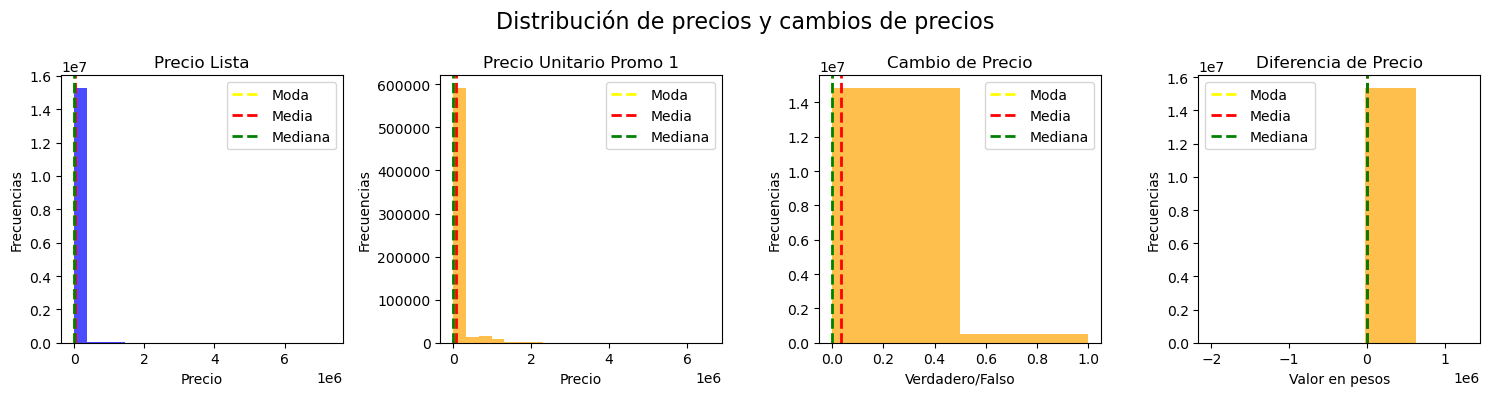

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].hist(df_agrupado['productos_precio_lista'], bins=20, color='blue', alpha=0.7)
ax[0].set_title('Precio Lista')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencias')

# medidas de tendencia central
ax[0].axvline(df_agrupado['productos_precio_lista'].mode()[0], color='yellow', ls='--', lw=2, label='Moda')
ax[0].axvline(df_agrupado['productos_precio_lista'].mean(), color='red', ls='--', lw=2, label='Media')
ax[0].axvline(df_agrupado['productos_precio_lista'].median(), color='green', ls='--', lw=2, label='Mediana')
ax[0].legend()



ax[1].hist(df_agrupado['productos_precio_unitario_promo1'], bins=20, color='orange', alpha=0.7) 
ax[1].set_title('Precio Unitario Promo 1')
ax[1].set_xlabel('Precio')
ax[1].set_ylabel('Frecuencias')
# medidas de tendencia central
ax[1].axvline(df_agrupado['productos_precio_unitario_promo1'].mode()[0], color='yellow', ls='--', lw=2, label='Moda')
ax[1].axvline(df_agrupado['productos_precio_unitario_promo1'].mean(), color='red', ls='--', lw=2, label='Media')
ax[1].axvline(df_agrupado['productos_precio_unitario_promo1'].median(), color='green', ls='--', lw=2, label='Mediana')
ax[1].legend()

ax[2].hist(df_agrupado['cambio_precio'].astype(int), bins=2, color='orange', alpha=0.7)
ax[2].set_title('Cambio de Precio')
ax[2].set_xlabel('Verdadero/Falso')
ax[2].set_ylabel('Frecuencias')
# medidas de tendencia central
ax[2].axvline(df_agrupado['cambio_precio'].mode()[0], color='yellow', ls='--', lw=2, label='Moda')
ax[2].axvline(df_agrupado['cambio_precio'].mean(), color='red', ls='--', lw=2, label='Media')
ax[2].axvline(df_agrupado['cambio_precio'].median(), color='green', ls='--', lw=2, label='Mediana')
ax[2].legend()

ax[3].hist(df_agrupado['cambio_diferencia'], bins=5, color='orange', alpha=0.7)
ax[3].set_title('Diferencia de Precio')
ax[3].set_xlabel('Valor en pesos')
ax[3].set_ylabel('Frecuencias')
# medidas de tendencia central
ax[3].axvline(df_agrupado['cambio_diferencia'].mode()[0], color='yellow', ls='--', lw=2, label='Moda')
ax[3].axvline(df_agrupado['cambio_diferencia'].mean(), color='red', ls='--', lw=2, label='Media')
ax[3].axvline(df_agrupado['cambio_diferencia'].median(), color='green', ls='--', lw=2, label='Mediana')
ax[3].legend()


plt.suptitle('Distribución de precios y cambios de precios', fontsize=16)
plt.tight_layout()
plt.show()

## estadistica descriptiva (clase 2)
* revision de la distribucion de los datos, tomar arreglos de los datos y revisar su “distribucion”, magnitudes o valores tomados en nuestra muestra
* revision de las medida de tendencia central (media, mediana, moda)
* medidas de dispersion
* Cuantiles y rango intercuartil
* Medidas de forma: skewness (asimetría) y curtosis
* Estadística descriptiva completa, simples numeros y magnitudes
* Determinar que metrica representa mejor cada variable analizada (pendiente)

In [ ]:
df_agrupado.loc[:,["productos_precio_lista","productos_precio_unitario_promo1","cambio_diferencia","productos_precio_unitario_promo2"]].describe()

,productos_precio_lista,productos_precio_unitario_promo1,cambio_diferencia,productos_precio_unitario_promo2
count,1.535180e+07,6.330130e+05,1.535180e+07,0.0
mean,1.000850e+04,6.895095e+04,3.106010e+00,NaN
std,8.069615e+04,2.504336e+05,9.723921e+02,NaN
min,1.000000e+01,4.500000e+01,-2.001000e+06,NaN
25%,1.579000e+03,1.090000e+03,0.000000e+00,NaN
50%,2.688000e+03,1.990000e+03,0.000000e+00,NaN
75%,4.975000e+03,4.599200e+03,0.000000e+00,NaN
max,7.300000e+06,6.570000e+06,1.290001e+06,NaN


In [22]:
# rango intercuartil 
def rango_intercuartil(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q2 = df[columna].quantile(0.50)  
    Q3 = df[columna].quantile(0.75)
    
    IQR = Q3 - Q1
    return IQR

print("Rango intercuartil (IQR) - productos_precio_lista:", rango_intercuartil(df_agrupado, 'productos_precio_lista'))
print("Rango intercuartil (IQR) - productos_precio_unitario_promo1:", rango_intercuartil(df_agrupado, 'productos_precio_unitario_promo1'))
print("Rango intercuartil (IQR) - cambio_diferencia:", rango_intercuartil(df_agrupado, "cambio_diferencia"))

Rango intercuartil (IQR) - productos_precio_lista: 3396.0
Rango intercuartil (IQR) - productos_precio_unitario_promo1: 3509.2
Rango intercuartil (IQR) - cambio_diferencia: 0.0


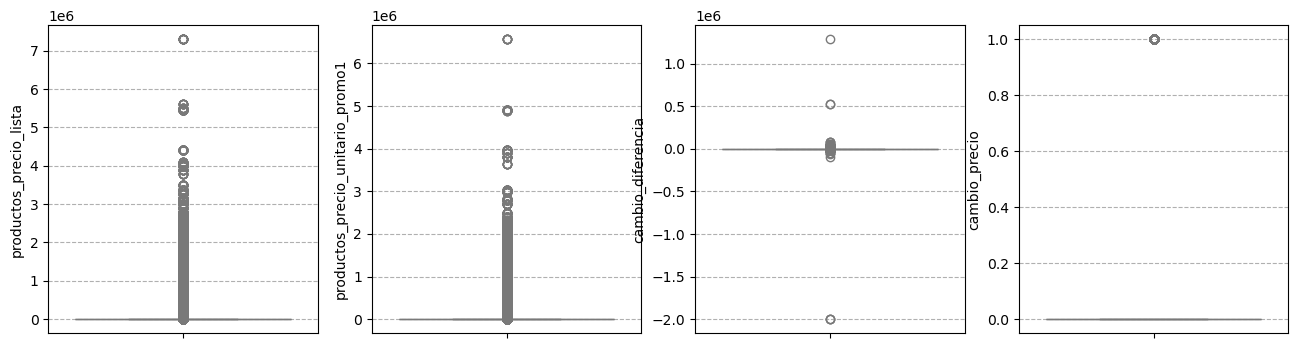

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

sns.boxplot(data=df_agrupado, y='productos_precio_lista', color="lightblue", ax=ax[0])
sns.boxplot(data=df_agrupado, y='productos_precio_unitario_promo1', color="lightblue", ax=ax[1])
sns.boxplot(data=df_agrupado, y='cambio_diferencia', color="lightblue", ax=ax[2])
sns.boxplot(data=df_agrupado, y='cambio_precio', color="lightblue", ax=ax[3])

ax[0].grid(axis='y', ls='--')
ax[1].grid(axis='y', ls='--')
ax[2].grid(axis='y', ls='--')
ax[3].grid(axis='y', ls='--')
# plt.legend(title='Especie', loc='lower right')


plt.show()

In [24]:

def imprimir_asimetria_curtosis(df, columna):
    print(f"Columna: {columna}")
    print("Asimetría (Skewness):", df[columna].skew())
    print("Curtosis:", df[columna].kurtosis())
    print()

imprimir_asimetria_curtosis(df_agrupado, 'productos_precio_lista')
imprimir_asimetria_curtosis(df_agrupado, 'productos_precio_unitario_promo1')
imprimir_asimetria_curtosis(df_agrupado, 'cambio_diferencia')
imprimir_asimetria_curtosis(df_agrupado, 'cambio_precio')

Columna: productos_precio_lista
Asimetría (Skewness): 20.050750899820464
Curtosis: 584.2188798102226

Columna: productos_precio_unitario_promo1
Asimetría (Skewness): 5.389385924942698
Curtosis: 42.530947045940515

Columna: cambio_diferencia
Asimetría (Skewness): -1529.6287583021292
Curtosis: 3717381.336207146

Columna: cambio_precio
Asimetría (Skewness): 5.177945539068823
Curtosis: 24.81112323790252



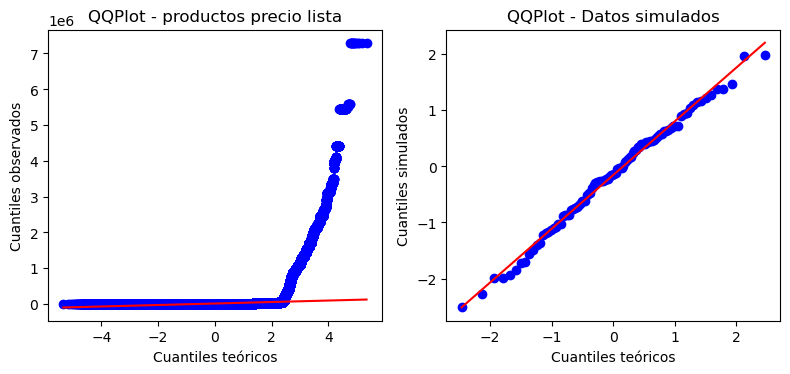

In [25]:
fig, (ax_ping, ax_normal) = plt.subplots(1, 2, figsize=(8, 4))

st.probplot(df_agrupado['productos_precio_lista'], dist="norm", plot=ax_ping)
ax_ping.set_title("QQPlot - productos precio lista")
ax_ping.set_xlabel("Cuantiles teóricos")
ax_ping.set_ylabel("Cuantiles observados")

# QQPlot para datos aleatorios con distribución normal
data = np.random.normal(loc=0, scale=1, size=100)
st.probplot(data, dist="norm", plot=ax_normal)
ax_normal.set_title("QQPlot - Datos simulados")
ax_normal.set_xlabel("Cuantiles teóricos")
ax_normal.set_ylabel("Cuantiles simulados")



plt.tight_layout()
plt.show()

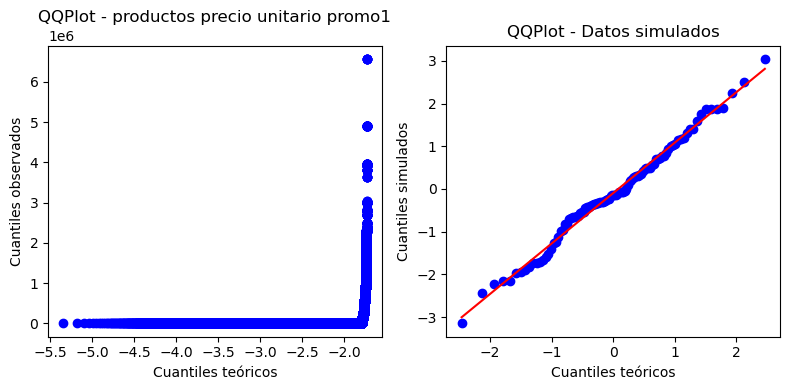

In [26]:
fig, (ax_ping, ax_normal) = plt.subplots(1, 2, figsize=(8, 4))

st.probplot(df_agrupado['productos_precio_unitario_promo1'], dist="norm", plot=ax_ping)
ax_ping.set_title("QQPlot - productos precio unitario promo1")
ax_ping.set_xlabel("Cuantiles teóricos")
ax_ping.set_ylabel("Cuantiles observados")

# QQPlot para datos aleatorios con distribución normal
data = np.random.normal(loc=0, scale=1, size=100)
st.probplot(data, dist="norm", plot=ax_normal)
ax_normal.set_title("QQPlot - Datos simulados")
ax_normal.set_xlabel("Cuantiles teóricos")
ax_normal.set_ylabel("Cuantiles simulados")


plt.tight_layout()
plt.show()

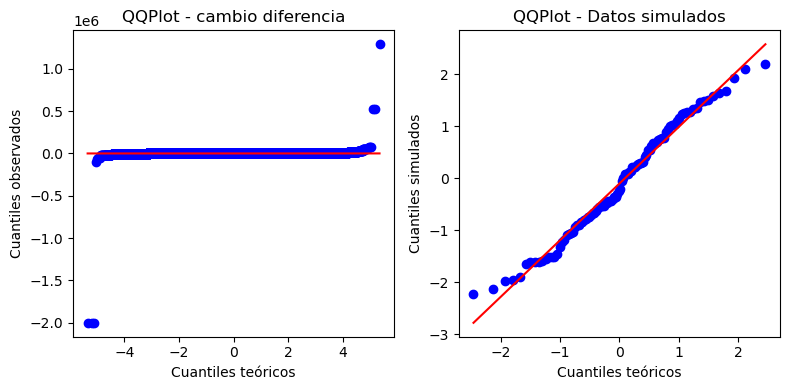

In [27]:
fig, (ax_ping, ax_normal) = plt.subplots(1, 2, figsize=(8, 4))

st.probplot(df_agrupado['cambio_diferencia'], dist="norm", plot=ax_ping)
ax_ping.set_title("QQPlot - cambio diferencia")
ax_ping.set_xlabel("Cuantiles teóricos")
ax_ping.set_ylabel("Cuantiles observados")

# QQPlot para datos aleatorios con distribución normal
data = np.random.normal(loc=0, scale=1, size=100)
st.probplot(data, dist="norm", plot=ax_normal)
ax_normal.set_title("QQPlot - Datos simulados")
ax_normal.set_xlabel("Cuantiles teóricos")
ax_normal.set_ylabel("Cuantiles simulados")


plt.tight_layout()
plt.show()

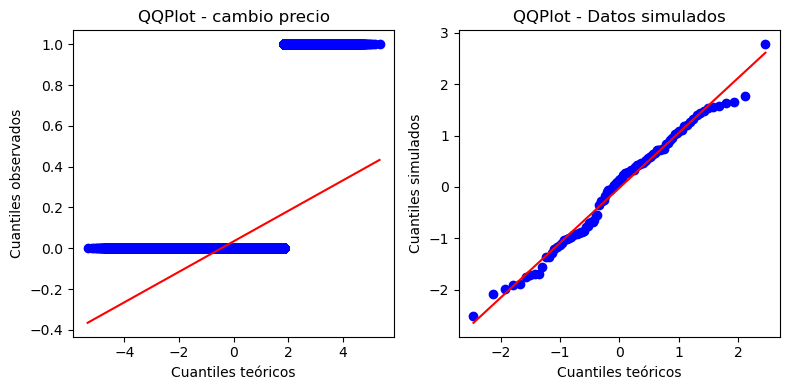

In [28]:
fig, (ax_ping, ax_normal) = plt.subplots(1, 2, figsize=(8, 4))

st.probplot(df_agrupado['cambio_precio'], dist="norm", plot=ax_ping)
ax_ping.set_title("QQPlot - cambio precio")
ax_ping.set_xlabel("Cuantiles teóricos")
ax_ping.set_ylabel("Cuantiles observados")

# QQPlot para datos aleatorios con distribución normal
data = np.random.normal(loc=0, scale=1, size=100)
st.probplot(data, dist="norm", plot=ax_normal)
ax_normal.set_title("QQPlot - Datos simulados")
ax_normal.set_xlabel("Cuantiles teóricos")
ax_normal.set_ylabel("Cuantiles simulados")


plt.tight_layout()
plt.show()

### Manejo de Outliers (clase 3)
* encontrar outlier, ya sea usando desviacion estandar o rango intercuartil
* decidir si reemplazarlos, eliminarlos, transformar todos los datos (normalizacion, estandarizacion), segmentar los datos

In [10]:
df_simplificado = df_agrupado.loc[:,["productos_precio_lista","productos_precio_unitario_promo1","cambio_diferencia","productos_precio_unitario_promo2",]]

In [30]:
# Métodos estadísticos para detectar outliers
Q1 = df_simplificado.quantile(0.25)
Q3 = df_simplificado.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = (df_simplificado < (Q1 - 1.5 * IQR)) | (df_simplificado > (Q3 + 1.5 * IQR))

# Método basado en desviación estándar
mean = df_simplificado.mean()
std = df_simplificado.std()
outliers_std = (df_simplificado < (mean - 3 * std)) | (df_simplificado > (mean + 3 * std))

/home/marck/anaconda3/envs/add-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


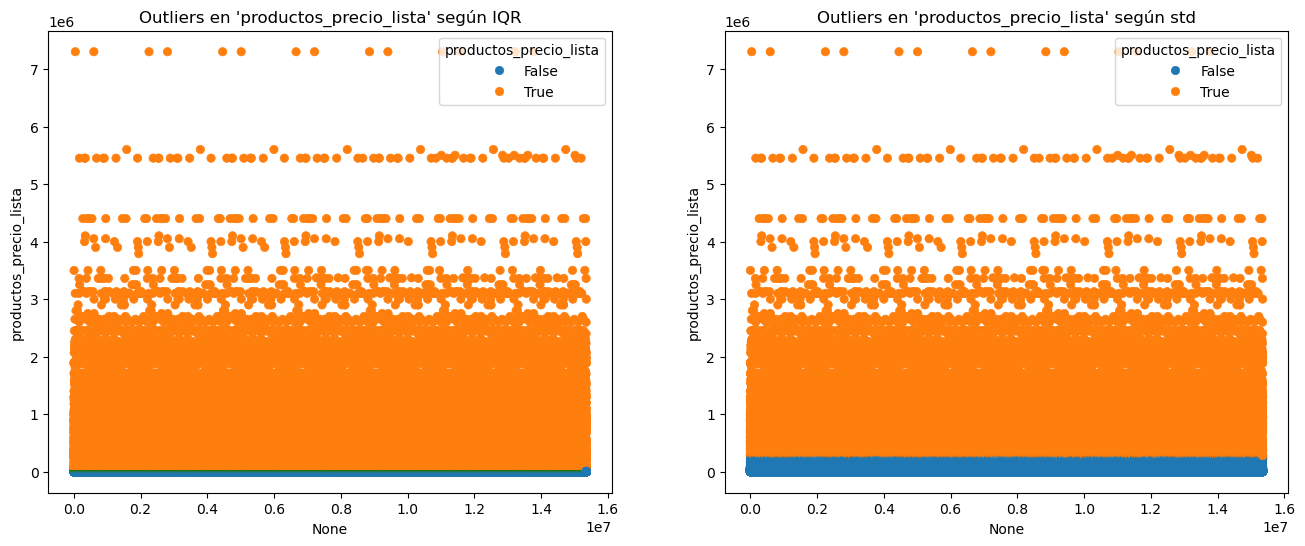

In [31]:
# Visualización con scatterplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=df_simplificado.index, y=df_simplificado['productos_precio_lista'], hue=outliers_iqr['productos_precio_lista'], edgecolor=None, ax=ax[0])
ax[0].set_title("Outliers en 'productos_precio_lista' según IQR")
sns.scatterplot(x=df_simplificado.index, y=df_simplificado['productos_precio_lista'], hue=outliers_std['productos_precio_lista'], edgecolor=None, ax=ax[1])
ax[1].set_title("Outliers en 'productos_precio_lista' según std")
plt.show()


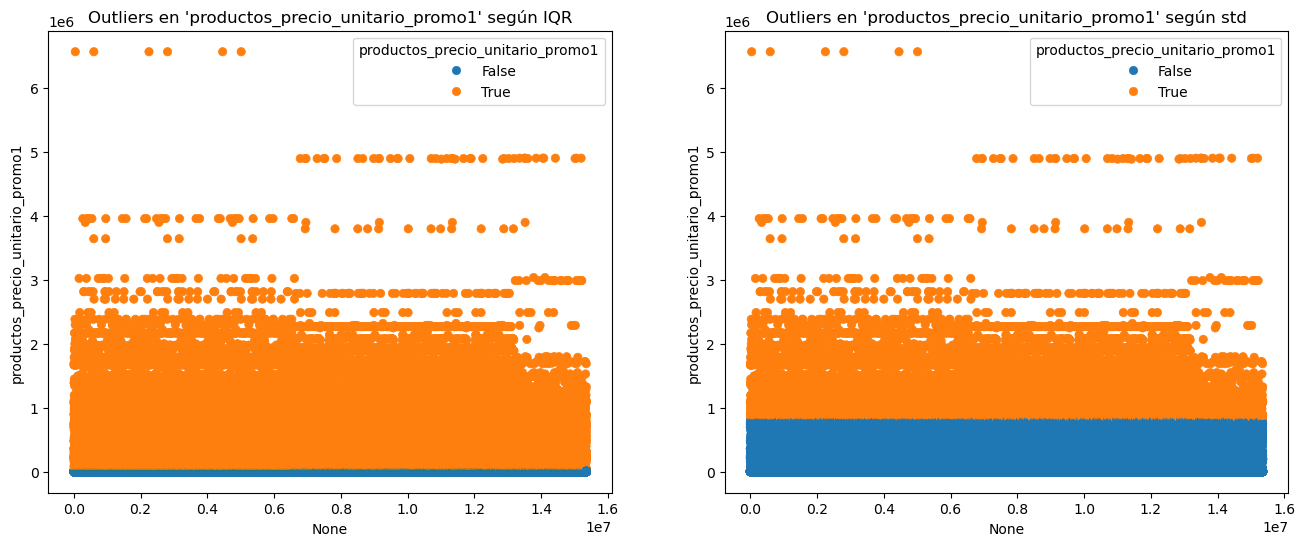

In [32]:
# Visualización con scatterplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=df_simplificado.index, y=df_simplificado['productos_precio_unitario_promo1'], hue=outliers_iqr['productos_precio_unitario_promo1'], edgecolor=None, ax=ax[0])
ax[0].set_title("Outliers en 'productos_precio_unitario_promo1' según IQR")
sns.scatterplot(x=df_simplificado.index, y=df_simplificado['productos_precio_unitario_promo1'], hue=outliers_std['productos_precio_unitario_promo1'], edgecolor=None, ax=ax[1])
ax[1].set_title("Outliers en 'productos_precio_unitario_promo1' según std")
plt.show()

/home/marck/anaconda3/envs/add-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


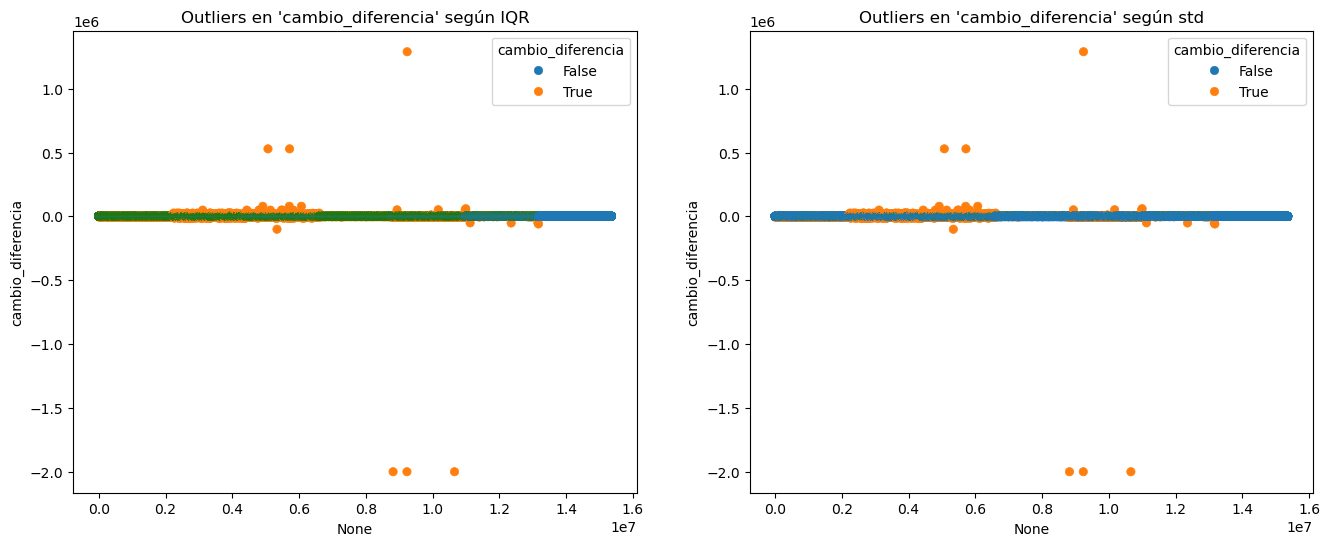

In [33]:
# Visualización con scatterplot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=df_simplificado.index, y=df_simplificado['cambio_diferencia'], hue=outliers_iqr['cambio_diferencia'], edgecolor=None, ax=ax[0])
ax[0].set_title("Outliers en 'cambio_diferencia' según IQR")
sns.scatterplot(x=df_simplificado.index, y=df_simplificado['cambio_diferencia'], hue=outliers_std['cambio_diferencia'], edgecolor=None, ax=ax[1])
ax[1].set_title("Outliers en 'cambio_diferencia' según std")
plt.show()

observando la distribucion de los datos se opta por segmentarlos

## Manejo de datos nulos

In [28]:
print("Total de datos:", len(df_agrupado))

print(f"columna productos_precio_lista:\t\t\tNo Nulos {df_agrupado['productos_precio_lista'].notnull().sum()} - Nulos {df_agrupado['productos_precio_lista'].isnull().sum()}")
print(f"columna productos_precio_unitario_promo1:\tNo Nulos {df_agrupado['productos_precio_unitario_promo1'].notnull().sum()} - Nulos {df_agrupado['productos_precio_unitario_promo1'].isnull().sum()}")
print(f"columna productos_leyenda_promo1:\t\tNo Nulos {df_agrupado['productos_leyenda_promo1'].notnull().sum()} - Nulos {df_agrupado['productos_leyenda_promo1'].isnull().sum()}")
print(f"columna productos_precio_unitario_promo2:\tNo Nulos {df_agrupado['productos_precio_unitario_promo2'].notnull().sum()} - Nulos {df_agrupado['productos_precio_unitario_promo2'].isnull().sum()}")
print(f"columna productos_leyenda_promo2:\t\tNo Nulos {df_agrupado['productos_leyenda_promo2'].notnull().sum()} - Nulos {df_agrupado['productos_leyenda_promo2'].isnull().sum()}")
print(f"columna cambio_diferencia:\t\t\tNo Nulos {df_agrupado['cambio_diferencia'].notnull().sum()} - Nulos {df_agrupado['cambio_diferencia'].isnull().sum()}")

Total de datos: 15351800
columna productos_precio_lista:			No Nulos 15351800 - Nulos 0
columna productos_precio_unitario_promo1:	No Nulos 633013 - Nulos 14718787
columna productos_leyenda_promo1:		No Nulos 633013 - Nulos 14718787
columna productos_precio_unitario_promo2:	No Nulos 0 - Nulos 15351800
columna productos_leyenda_promo2:		No Nulos 0 - Nulos 15351800
columna cambio_diferencia:			No Nulos 15351800 - Nulos 0
